# Introduction

The aim of this project is to perform satellite image classification on the EuroSAT dataset, see https://github.com/phelber/EuroSAT. The authors present a novel dataset based on  Sentinel-2 satellite images. The dataset has 13 spectral bands, and includes 10 classes with 27,000 labelled and geo-referenced images. This project will compare various CNN models to the state-of-the-art vision transformer model.

The notebook below tests a modified ResNet model on the EuroSAT dataset. The ResNet model is based on the following paper: https://arxiv.org/abs/1512.03385v1

The implementation is based on the tutorial below:
https://colab.research.google.com/drive/15oRSLVWUfxkQd3oEhuNIHzT-l5phfutO?usp=sharing#scrollTo=AKm6UgGpix0B

# Modifications #

1. Apply data augmentation to a higher proportion of images in the training set.

2. Modify the number of epochs by using EarlyStopping, a function in Keras that stops training once the model's performance stops improving.

3. Include a Batch Normalisation and Dropout Layer in the CNN model.

Changes inspired by background reading as well as this paper: https://arxiv.org/abs/2201.03299










In [1]:
# first, import required libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, ResNet152, preprocess_input
from tensorflow.keras.utils import plot_model

# Data Preparation #
This step involves preparing the data, gathering the class names, and load the dataset to be used.

In [ ]:
# get dataset
dataset = tfds.builder('eurosat')
info = dataset.info

In [ ]:
# get class names - we have 10 classes in the EuroSAT dataset
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
# select the training data
list(info.splits.keys())

['train']

In [ ]:
# load the dataset from TensorFlow Datasets 
# in this experiment, we will have a 80/20/20 train/test/validate split
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteNPDWJI/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
# load next batch to be trained
datapoint = next(iter(train))

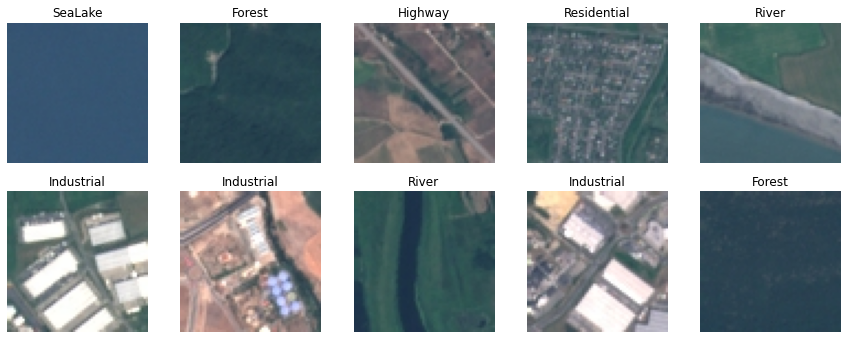

In [ ]:
# view samples of the dataset
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(10))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [ ]:
# set the number of epochs, batch, buffer size 
NUM_EPOCHS = 15 # note that we increase the number of epochs to 15 to measure the effect of the EarlyStopping function
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# we will have 180x180 images
IMAGE_SHAPE = [180, 180]
NUM_CLASSES = info.features["label"].num_classes

In [ ]:
# we create a random value to evaluate whether we apply augmentation to the input images
# this is designed to prevent overfitting
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.39922714>

**Change 1:** Apply data augmentation techniques if the uniform value is above a threshold (0.25) - this is reduced from 0.5 in the original implementation

In [ ]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.25:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [ ]:
# use prefetch to prepare the training dataset
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

# Build the Model: Modified ResNet #
We use Keras to build the ResNet152 model, a ResNet with 152 layers.

**Change 2:** Include a Batch Normalisation and Dropout Layer in the CNN model.


In [ ]:
# build model using ResNet152
resnet = ResNet152(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

# set trainable layers to false
for layer in resnet.layers:
  layer.trainable = False

# we employ a pooling, flatten, and dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)

# we add a Batch Normalisation and Dropout layer to the network
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
predict = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predict)

In [ ]:
# compile model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

# Train the Model
We train the ResNet model for 15 epochs, including the EarlyStopping function from Keras.

**Change 3:** Modify the number of epochs by using EarlyStopping, a function in Keras that stops training once the model's performance stops improving. We set patience equal to 3, where this callback function stops the training when we have no improvement in accuracy after 3 consecutive epochs.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/15
337/337 [==============================] - 140s 390ms/step - loss: 0.3369 - accuracy: 0.9035 - val_loss: 0.1656 - val_accuracy: 0.9494
Epoch 2/15
337/337 [==============================] - 129s 384ms/step - loss: 0.1541 - accuracy: 0.9501 - val_loss: 0.1523 - val_accuracy: 0.9606
Epoch 3/15
337/337 [==============================] - 129s 383ms/step - loss: 0.0976 - accuracy: 0.9681 - val_loss: 0.1540 - val_accuracy: 0.9580
Epoch 4/15
337/337 [==============================] - 129s 383ms/step - loss: 0.0827 - accuracy: 0.9722 - val_loss: 0.1536 - val_accuracy: 0.9606
Epoch 5/15
337/337 [==============================] - 129s 383ms/step - loss: 0.0760 - accuracy: 0.9742 - val_loss: 0.2179 - val_accuracy: 0.9524
Epoch 6/15
337/337 [==============================] - 129s 383ms/step - loss: 0.0710 - accuracy: 0.9777 - val_loss: 0.1664 - val_accuracy: 0.9635
Epoch 7/15
337/337 [==============================] - 129s 383ms/step - loss: 0.0700 - accuracy: 0.9787 - val_loss: 0.2068 -

In [ ]:
# plot the model's performance on the validation set
import pandas as pd

# plot summary for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modified ResNet model accuracy')
plt.ylabel('accuracy')
plt.xlim(0,14)
plt.ylim(0.91, 1.00)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure(figsize=(36,36))
plt.show()

# plot summary for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modified ResNet model loss')
plt.ylabel('loss')
plt.xlim(0,14)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure(figsize=(36,36))
plt.show()

In [ ]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Evaluate the Model
Evaluate the model's performance on the test dataset. 
Compute loss and accuracy.

In [ ]:
eval = model.evaluate(test_dataset)
print('Loss: ', eval[0])
print('Accuracy: ', eval[1])

43/43 [==============================] - 14s 322ms/step - loss: 0.2281 - accuracy: 0.9552
Loss:  0.22805503010749817
Accuracy:  0.9551851749420166


# Show Predictions
Show how well the model classifies images after training.

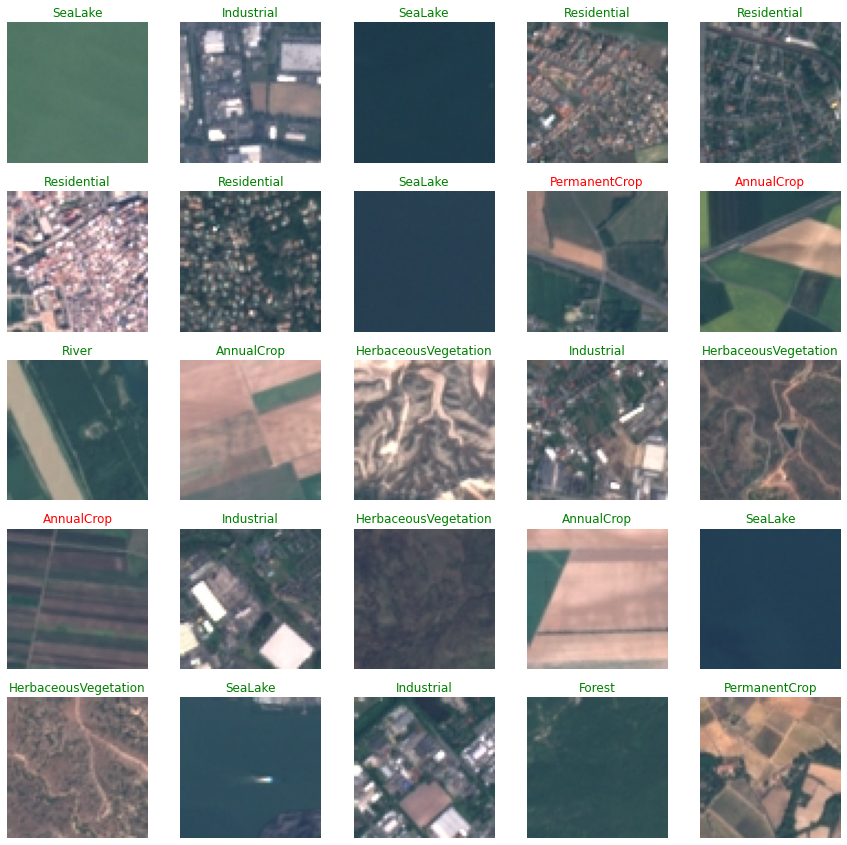

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()